In [44]:
import chardet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime  
# 读取二进制文件内容
file_name = 'tick_data.csv'
with open(file_name, 'rb') as f:
    result = chardet.detect(f.read())

# 获取检测到的编码格式
encoding = result['encoding']

# 使用检测到的编码格式读取文件
tick_data = pd.read_csv(
    file_name,
    encoding=encoding,
)
tick_data.drop(columns=['市场代码', '证券代码'], inplace=True)
tick_data['时间'] = pd.to_datetime(tick_data['时间'])
tick_data = tick_data.sort_values(by='时间')



In [62]:
# tick_data['买一量价'] = tick_data['买一量'] * tick_data['买一价']
# tick_data['买二量价'] = tick_data['买二量'] * tick_data['买二价']
# tick_data['买三量价'] = tick_data['买三量'] * tick_data['买三价']
# tick_data['买四量价'] = tick_data['买四量'] * tick_data['买四价']
# tick_data['买五量价'] = tick_data['买五量'] * tick_data['买五价']
# tick_data['卖一量价'] = tick_data['卖一量'] * tick_data['卖一价']
# tick_data['卖二量价'] = tick_data['卖二量'] * tick_data['卖二价']
# tick_data['卖三量价'] = tick_data['卖三量'] * tick_data['卖三价']
# tick_data['卖四量价'] = tick_data['卖四量'] * tick_data['卖四价']
# tick_data['卖五量价'] = tick_data['卖五量'] * tick_data['卖五价']

Epoch [1/30], Loss: 0.2751460075378418
Epoch [2/30], Loss: 19.694917678833008
Epoch [3/30], Loss: 0.42156779766082764
Epoch [4/30], Loss: 0.07346347719430923
Epoch [5/30], Loss: 1.237066388130188
Epoch [6/30], Loss: 0.2396458238363266
Epoch [7/30], Loss: 0.8093753457069397
Epoch [8/30], Loss: 0.6293887495994568
Epoch [9/30], Loss: 0.28438183665275574
Epoch [10/30], Loss: 0.08175385743379593
Epoch [11/30], Loss: 0.09150074422359467
Epoch [12/30], Loss: 0.2149970829486847
Epoch [13/30], Loss: 0.25638312101364136
Epoch [14/30], Loss: 0.1814548373222351
Epoch [15/30], Loss: 0.08809409290552139
Epoch [16/30], Loss: 0.0631619468331337
Epoch [17/30], Loss: 0.11062301695346832
Epoch [18/30], Loss: 0.15997645258903503
Epoch [19/30], Loss: 0.15310212969779968
Epoch [20/30], Loss: 0.10277802497148514
Epoch [21/30], Loss: 0.06399601697921753
Epoch [22/30], Loss: 0.0706053152680397
Epoch [23/30], Loss: 0.10384941846132278
Epoch [24/30], Loss: 0.11994907259941101
Epoch [25/30], Loss: 0.1015269830822

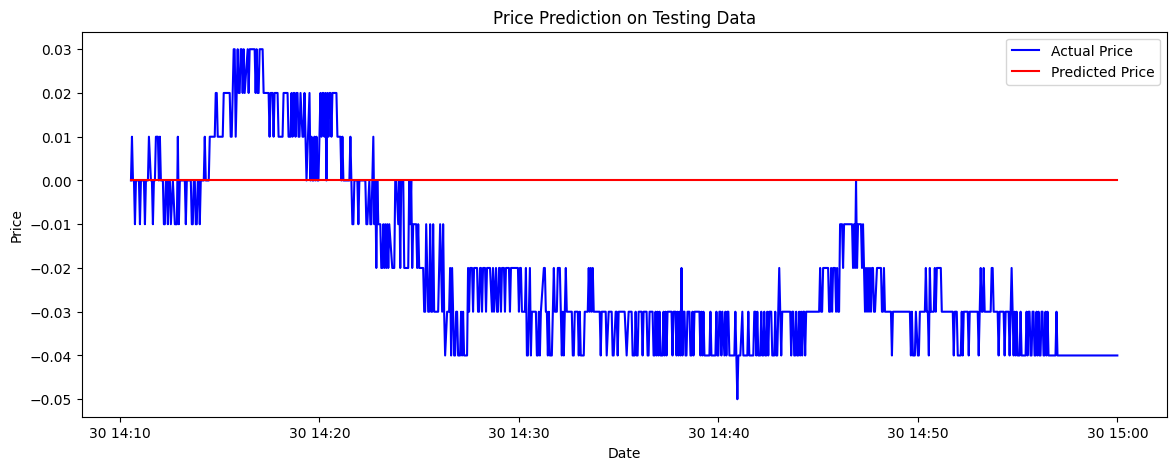

In [70]:

# 数据归一化
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))

scaled_X = scaler_X.fit_transform(tick_data[['买一价', '买二价', '买三价', '买四价',
       '买五价', '卖一价', '卖二价', '卖三价', '卖四价', '卖五价', '买一量', '买二量', '买三量', '买四量',
       '买五量', '卖一量', '卖二量', '卖三量', '卖四量', '卖五量']].values)
scaled_Y = scaler_Y.fit_transform(tick_data[['最新价']].values)

scaled_data = np.concatenate([scaled_X, scaled_Y], axis=1)
# 创建训练、验证和测试数据集
train_size = int(len(scaled_data) * 0.7)
val_size = int(len(scaled_data) * 0.1)
train_data, val_data, test_data = scaled_data[:train_size], scaled_data[train_size:train_size+val_size], scaled_data[train_size+val_size:]

# 创建数据集函数
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step):
        a = data[i:(i + time_step), :-1]
        X.append(a)
        Y.append(data[i + time_step, -1])
    return np.array(X), np.array(Y)

time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 转换为Tensor
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float().unsqueeze(1)
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float().unsqueeze(1)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float().unsqueeze(1)


class CNN_LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(CNN_LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.conv1 = nn.Conv1d(input_size, input_size, kernel_size=5, padding=1)  # 1D convolution
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # change to (batch, channel, time_step)
        x = self.conv1(x)
        x = x.permute(0, 2, 1)  # change back to (batch, time_step, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


# 模型参数
input_size = 20

hidden_size = 50  # TODO
num_layers = 2  # TODO
output_size = 1

model = CNN_LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# 训练模型
num_epochs = 30
for epoch in range(num_epochs):
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# 预测
model.eval()
train_predict = model(X_train).detach().numpy()
test_predict = model(X_test).detach().numpy()

# 反归一化
train_predict = scaler_Y.inverse_transform(train_predict)
test_predict = scaler_Y.inverse_transform(test_predict)

# 计算均方误差
mse_train = mean_squared_error(scaler_Y.inverse_transform(y_train.detach().numpy()), train_predict)
mse_test = mean_squared_error(scaler_Y.inverse_transform(y_test.detach().numpy()), test_predict)

# 绘制测试数据的预测结果
plt.figure(figsize=(14, 5))
actual_price = scaler_Y.inverse_transform(test_data[time_step:, -1].reshape(-1, 1))
predicted_price = test_predict
plt.plot(tick_data['时间'][train_size + val_size + time_step:], actual_price - actual_price[0], color='blue', label='Actual Price')
plt.plot(tick_data['时间'][train_size + val_size + time_step:], predicted_price - predicted_price[0], color='red', label='Predicted Price')
plt.title('Price Prediction on Testing Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [71]:
predicted_price

array([[13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],
       [13.079602],


In [57]:
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split

# 定义参数网格
param_grid = {
    'lr': [0.001, 0.01, 0.1],
    'hidden_size': [50, 100, 150],
    'num_layers': [1, 2, 3]
}

# 创建参数网格
grid = ParameterGrid(param_grid)

# 存储每一组参数的最佳损失
best_loss = float('inf')
best_params = None

# 初始化早停参数
early_stop_threshold = 5

for params in grid:
    model = CNN_LSTMModel(input_size, params['hidden_size'], output_size, params['num_layers'])
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])

    # 训练模型
    num_epochs = 10
    best_val_loss = float('inf')
    early_stop_counter = 0
    for epoch in range(num_epochs):
        outputs = model(X_train)
        optimizer.zero_grad()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        # 计算验证损失
        val_loss = calculate_validation_loss(model, X_val, y_val)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
        if early_stop_counter >= early_stop_threshold:
            print('Early stopping...')
            break

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

    # 预测
    model.eval()
    train_predict = model(X_train).detach().numpy()
    test_predict = model(X_test).detach().numpy()

    # 反归一化
    train_predict = scaler_Y.inverse_transform(train_predict)
    test_predict = scaler_Y.inverse_transform(test_predict)

    # 计算均方误差
    mse_train = mean_squared_error(scaler_Y.inverse_transform(y_train.detach().numpy()), train_predict)
    mse_test = mean_squared_error(scaler_Y.inverse_transform(y_test.detach().numpy()), test_predict)
    
    print(f'Parameters: {params}, Train MSE: {mse_train}, Test MSE: {mse_test}')
    
    # 如果这一组参数的测试损失更低，则更新最佳损失和最佳参数
    if mse_test < best_loss:
        best_loss = mse_test
        best_params = params

print(f'Best parameters: {best_params}, Best loss: {best_loss}')


Epoch [1/30], Loss: 0.17362836003303528
Epoch [2/30], Loss: 0.1496688276529312
Epoch [3/30], Loss: 0.12758848071098328
Epoch [4/30], Loss: 0.10714364796876907
Epoch [5/30], Loss: 0.08875204622745514
Epoch [6/30], Loss: 0.07336801290512085
Epoch [7/30], Loss: 0.06245148926973343
Epoch [8/30], Loss: 0.05781976133584976
Epoch [9/30], Loss: 0.060559339821338654
Epoch [10/30], Loss: 0.06752140820026398
Epoch [11/30], Loss: 0.07199161499738693
Epoch [12/30], Loss: 0.07166112214326859
Epoch [13/30], Loss: 0.06811238080263138
Epoch [14/30], Loss: 0.06364410370588303
Early stopping...
Parameters: {'hidden_size': 50, 'lr': 0.001, 'num_layers': 1}, Train MSE: 0.005898462142795324, Test MSE: 0.002635061042383313
Epoch [1/30], Loss: 0.4843713641166687
Epoch [2/30], Loss: 0.4392411708831787
Epoch [3/30], Loss: 0.39927685260772705
Epoch [4/30], Loss: 0.36272233724594116
Epoch [5/30], Loss: 0.32828018069267273
Epoch [6/30], Loss: 0.29503557085990906
Epoch [7/30], Loss: 0.26230451464653015
Epoch [8/30]